In [1]:
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

from IPython.display import display


In [2]:
%load_ext autoreload
%autoreload 2
    
from simulation_tools import Population
from simulation_tools import Transformation
from simulation_tools import Metric
from simulation_tools import Experiment


In [3]:
# Load data:
SYNTHETIC_DATA = './synthetic_data/'

dummy = False

if dummy:

    location_attributes = pd.read_csv(SYNTHETIC_DATA+'location_attributes_dummy.csv')
    location_profiles = pd.read_csv(SYNTHETIC_DATA+'location_profiles_dummy.csv')

else:
    
    location_attributes = pd.read_csv(SYNTHETIC_DATA+'location_attributes_census.csv')
    location_attributes['location_name'] = location_attributes['location_id']

    location_profiles = pd.read_csv(SYNTHETIC_DATA+'location_profiles_census.csv')
    location_profiles['location_name'] = location_profiles['location_id']
    
    # Limit to one state and divide population by a constant to get reasonable sample size.
    state = 'New York'
    constant = 1000
    location_attributes = location_attributes[location_attributes['location_state']==state]
    location_profiles = location_profiles[location_profiles['location_state']==state]
    location_attributes['population'] = (location_attributes['population']/constant).astype(int)
    
    # Rescale standard deviations:
    location_profiles['worktravel_std'] = np.round(location_profiles['worktravel_std']/20,1)
    location_profiles['socialtravel_std'] = np.round(location_profiles['socialtravel_std']/20,1)
    location_profiles['grocerytravel_std'] = np.round(location_profiles['grocerytravel_std']/20,1)
    
print("Loaded data for {} locations ({} people).".format(
    len(location_attributes),location_attributes['population'].sum()
))

display(location_attributes.head())
display(location_profiles.head())


Loaded data for 39 locations (18528 people).


,location_id,location_county,location_state,location_name,population,density,employment_rate,wealth_rate
44,0500000US36013,Chautauqua County,New York,0500000US36013,127,rural,0.576,0.526
45,0500000US36029,Erie County,New York,0500000US36029,919,urban,0.620,0.650
46,0500000US36045,Jefferson County,New York,0500000US36045,111,rural,0.631,0.620
47,0500000US36047,Kings County,New York,0500000US36047,2582,urban,0.635,0.702
48,0500000US36053,Madison County,New York,0500000US36053,70,urban,0.609,0.579


,location_id,location_county,location_state,location_name,wealth_status,employment_status,phoneownership_rate,worktravel_mean,worktravel_std,socialtravel_mean,socialtravel_std,grocerytravel_mean,grocerytravel_std
176,0500000US36013,Chautauqua County,New York,0500000US36013,0,0,0.641842,0.0,0.0,24.5,2.9,21.3,1.9
177,0500000US36013,Chautauqua County,New York,0500000US36013,0,1,0.641842,28.2,2.1,24.5,2.9,21.3,1.9
178,0500000US36013,Chautauqua County,New York,0500000US36013,1,0,0.806005,0.0,0.0,28.7,3.1,27.4,3.7
179,0500000US36013,Chautauqua County,New York,0500000US36013,1,1,0.806005,31.3,1.8,28.7,3.1,27.4,3.7
180,0500000US36029,Erie County,New York,0500000US36029,0,0,0.690369,0.0,0.0,18.2,2.5,12.0,2.2


In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
pd.set_option('display.max_rows', 500)

import matplotlib.pyplot as plt
import seaborn as sns

In [378]:
#population = Population(location_attributes, location_profiles, random_state=221)
#transformation = Transformation(population, behavior='total_compliance', random_state=221)
#metric = Metric(population, transformation, method='median_person', random_state=221)

experiment1 = Experiment(
    location_attributes, location_profiles, behavior='total_compliance', method='average_person',
    trials=10, show_progress=True, experiment_name=None, random_state=221,
)


In [519]:
full_df = experiment1.get_results(style='df')


# df = full_df_reset[full_df_reset['population_name']=='trial3']
full_df.reset_index(inplace=True)

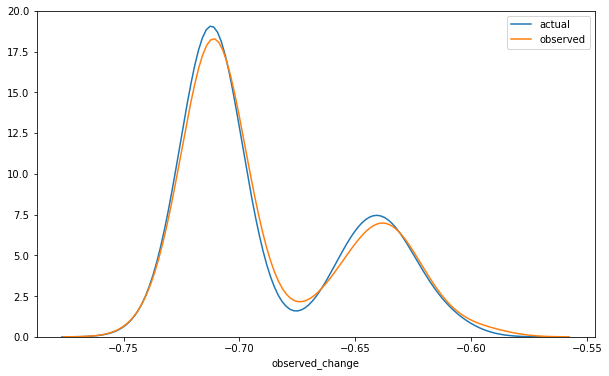

In [520]:
actualchange = full_df['actual_change']
observedchange = full_df['observed_change']

plt.figure(figsize=(10,6))
sns.distplot(actualchange,hist=False,label='actual')
sns.distplot(observedchange,hist=False,label='observed')
plt.legend()
plt.show()

print(stats.ttest_rel(actualchange,observedchange))
print(stats.ks_2samp(actualchange,observedchange))

In [521]:
print(stats.ttest_rel(actualchange,observedchange))
print(stats.ks_2samp(actualchange,observedchange))

Ttest_relResult(statistic=-3.772838943180442, pvalue=0.00018652702027116257)
Ks_2sampResult(statistic=0.06666666666666667, pvalue=0.35179443856266657)


In [518]:
print(stats.ttest_rel(actual_dist,obs_dist))
print(stats.ks_2samp(actual_dist,obs_dist))

Ttest_relResult(statistic=-3.772838943180442, pvalue=0.00018652702027116257)
Ks_2sampResult(statistic=0.06666666666666667, pvalue=0.35179443856266657)


In [222]:
actual = df[['location_name','actual_before', 'actual_after']].rename(columns={'location_name':'loc','actual_before':'before','actual_after':'after'})
observed = df[['location_name','observed_before', 'observed_after']].rename(columns={'location_name':'loc','observed_before':'before','observed_after':'after'})

actual['group']='actual'
observed['group']='observed'

newdf = actual.append(observed)

In [223]:
df_i = pd.melt(newdf,id_vars=['loc','group'],var_name='time',value_vars=['before','after'])
df_i.head()

,loc,group,time,value
0,0500000US36001,actual,before,48.997638
1,0500000US36005,actual,before,43.762572
2,0500000US36007,actual,before,70.347101
3,0500000US36009,actual,before,67.576132
4,0500000US36011,actual,before,69.334686


In [224]:
mod = smf.ols(formula='value ~ time + group + time:group', data=df_i)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     141.7
Date:                Sat, 02 May 2020   Prob (F-statistic):           7.98e-44
Time:                        19:03:52   Log-Likelihood:                -560.52
No. Observations:                 156   AIC:                             1129.
Df Residuals:                     152   BIC:                             1141.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [213]:
mod = smf.ols(formula='value ~ time + group + time:group', data=df_i)
res = mod.fit()
print(res.pvalues[3])

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     1752.
Date:                Sat, 02 May 2020   Prob (F-statistic):               0.00
Time:                        18:52:43   Log-Likelihood:                -5661.7
No. Observations:                1560   AIC:                         1.133e+04
Df Residuals:                    1556   BIC:                         1.135e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

0.9466562124355862

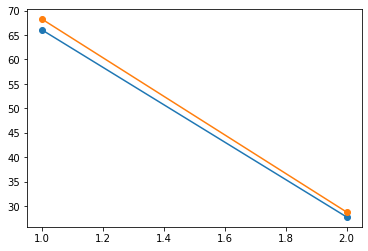

In [210]:
i=7
plt.plot([1,2],[actual_before[i],actual_after[i]],'-o')
plt.plot([1,2],[obs_before[i],obs_after[i]],'-o')
plt.show()

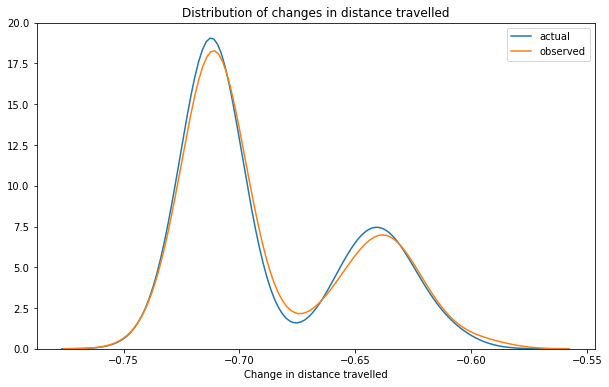

Ttest_relResult(statistic=-3.772838943180442, pvalue=0.00018652702027116257)
Ks_2sampResult(statistic=0.06666666666666667, pvalue=0.35179443856266657)


In [566]:
def distributionplot(df_in):
    '''
    Create Distribution plots for the two delta vectors
    '''
    # Copy DF and flatten indices
    full_df_reset = df_in.copy(deep=True)
    full_df_reset.reset_index(inplace=True)

    # Get distributions of actual and observed change
    actual_dist = full_df_reset['actual_change']
    obs_dist = full_df_reset['observed_change']

    plt.figure(figsize=(10,6))
    sns.distplot(actual_dist,hist=False,label='actual')
    sns.distplot(obs_dist,hist=False,label='observed')
    plt.xlabel('Change in distance travelled')
    plt.title('Distribution of changes in distance travelled')
    plt.legend()
    plt.show()
    
    import scipy.stats as stats
    print(stats.ttest_rel(actual_dist,obs_dist))
    print(stats.ks_2samp(actual_dist,obs_dist))
    
distributionplot(full_df)

In [568]:
def rankingDFs(df_in,ntrials):
    '''
    Creates 3 dataframes of actual, observed and difference 
    representing rankings in change in distance traveled before/after across multiple trials
    '''
    full_df_reset = df_in.copy(deep=True)
    full_df_reset.reset_index(inplace=True)
    
    # Set up 3 dataframes
    df_rankchanges = pd.DataFrame(index=np.unique(full_df_reset.location_name))
    df_rankactual = pd.DataFrame(index=np.unique(full_df_reset.location_name))
    df_rankobs = pd.DataFrame(index=np.unique(full_df_reset.location_name))

    # Loop through each trial and compute ranks for observed,actual and compute delta-rank
    # Put them in their own DFs
    for trialnum in range(1,ntrials+1):

        this_trial = full_df_reset.copy()

        # Extract just the current trial in question
        thistrialname = 'trial'+str(trialnum)
        this_trial = this_trial[this_trial['population_name']==thistrialname]
        this_trial.set_index('location_name',inplace=True)

        # Compute ranks for this trial
        actual_rank_i=(-this_trial['actual_change']).rank()
        obs_rank_i=(-this_trial['observed_change']).rank()

        # Add actual and observed ranks for current trial to DFs
        df_rankactual[thistrialname]=actual_rank_i
        df_rankobs[thistrialname]=obs_rank_i

        # compute differnce in ranks for current trial and add to DF
        thisrankchange = 'rank_change_'+str(trialnum)
        df_rankchanges[thisrankchange]=obs_rank_i-actual_rank_i
        

    return(df_rankactual,df_rankobs,df_rankchanges)

In [569]:
this_trial = full_df_reset.copy()

# Extract just the current trial in question
this_trial = this_trial[this_trial['population_name']=='trial1']
this_trial.set_index('location_name',inplace=True)

In [575]:
this_trial.sort_values('actual_change').tail()

,experiment_name,population_name,actual_before,actual_after,actual_delta,actual_change,observed_before,observed_after,observed_delta,observed_change
location_name,,,,,,,,,,
0500000US36007,experiment16,trial1,70.386703,24.783810,-45.602893,-0.647891,70.109481,24.571130,-45.538351,-0.649532
0500000US36019,experiment16,trial1,66.581250,23.502717,-43.078533,-0.647007,67.634284,23.515698,-44.118586,-0.652311
0500000US36013,experiment16,trial1,68.086499,24.238417,-43.848082,-0.644006,68.855803,24.606994,-44.248809,-0.642630
0500000US36011,experiment16,trial1,68.678759,25.435903,-43.242856,-0.629639,68.991658,25.794840,-43.196818,-0.626117
0500000US36105,experiment16,trial1,71.006983,27.044028,-43.962955,-0.619136,70.019619,26.380143,-43.639476,-0.623246


In [576]:
(this_trial['actual_change']).rank()

location_name
0500000US36001     8.0
0500000US36005    10.0
0500000US36007    35.0
0500000US36009    27.0
0500000US36011    38.0
0500000US36013    37.0
0500000US36015    31.0
0500000US36019    36.0
0500000US36027    12.0
0500000US36029    13.0
0500000US36045    32.0
0500000US36047    20.0
0500000US36051     7.0
0500000US36053    26.0
0500000US36055    16.0
0500000US36059    11.0
0500000US36061     3.0
0500000US36063    25.0
0500000US36065    24.0
0500000US36067    22.0
0500000US36069     4.0
0500000US36071    15.0
0500000US36075     5.0
0500000US36079     1.0
0500000US36081    18.0
0500000US36083    19.0
0500000US36085    23.0
0500000US36087    21.0
0500000US36089    34.0
0500000US36091     6.0
0500000US36093     2.0
0500000US36101    30.0
0500000US36103     9.0
0500000US36105    39.0
0500000US36109    33.0
0500000US36111    29.0
0500000US36113    28.0
0500000US36117    14.0
0500000US36119    17.0
Name: actual_change, dtype: float64

In [541]:
def topFivePlot(df_rankactual,df_rankobs,experiment):
    '''
    Create Actual/Observed grouped bar plot of percent of trials county is in top5 most reduced travel
    '''
    # Create new top5 DF
    df_top5 = pd.DataFrame(index=np.unique(df_rankactual.index))

    # Compute percentage of actual and observed ranks that are within top5
    df_top5['Actual'] = df_rankactual.copy().apply(lambda row: len(np.where(row<=5)[0])/10 ,axis=1)
    df_top5['Observed'] = df_rankobs.copy().apply(lambda row: len(np.where(row<=5)[0])/10 ,axis=1)
    df_top5.reset_index(inplace=True)
    df_top5.rename(columns={'index':'Location'},inplace=True)
    
    # Reformat DF for catplot
    df_top5_melt = pd.melt(df_top5,id_vars='Location',var_name='Condition',value_name='% Trials in Top 5',value_vars=['Actual','Observed'])
    df_top5_melt.sort_values('Location',inplace=True)
    
    # Plot top5
    plt.figure(figsize=(20,8))
    g=sns.catplot(x='Location', y="% Trials in Top 5", height=8, aspect=2,hue="Condition", data=df_top5_melt, kind="bar")
    g.set_xticklabels(rotation=90)
    plt.title(f'Percent of time county is in Top5 most reduced travel for {experiment} test')
    plt.show()

In [567]:
def rankchangesPlot(df_rankchanges,experiment):
    '''
    Create barplot of how mean ranking of most-least decrease in travel varies across counties
    with error bars representing between trial variety
    '''
    df_rankchanges_all = df_rankchanges.copy(deep=True)
    df_rankchanges_all['mean']=df_rankchanges.mean(axis=1)
    df_rankchanges_all['minus']=df_rankchanges.mean(axis=1)-df_trials.min(axis=1)
    df_rankchanges_all['plus']=df_rankchanges.max(axis=1)-df_trials.mean(axis=1)
    
    plt.figure(figsize=(20,8))
    plt.bar(df_rankchanges_all.index,df_rankchanges_all['mean'],color='blue',yerr=(df_rankchanges_all['plus'],df_rankchanges_all['minus']),capsize=5)
    plt.xticks(rotation=90)
    plt.title(f'Change between actual/observed ranking of travel decrease across counties for {experiment} test')
    plt.ylabel('Ranks changed')
    plt.xlabel('County ID')
    plt.show()

In [558]:
a,b,c = rankingDFs(experiment1.get_results(style='df'),10)

<Figure size 1440x576 with 0 Axes>

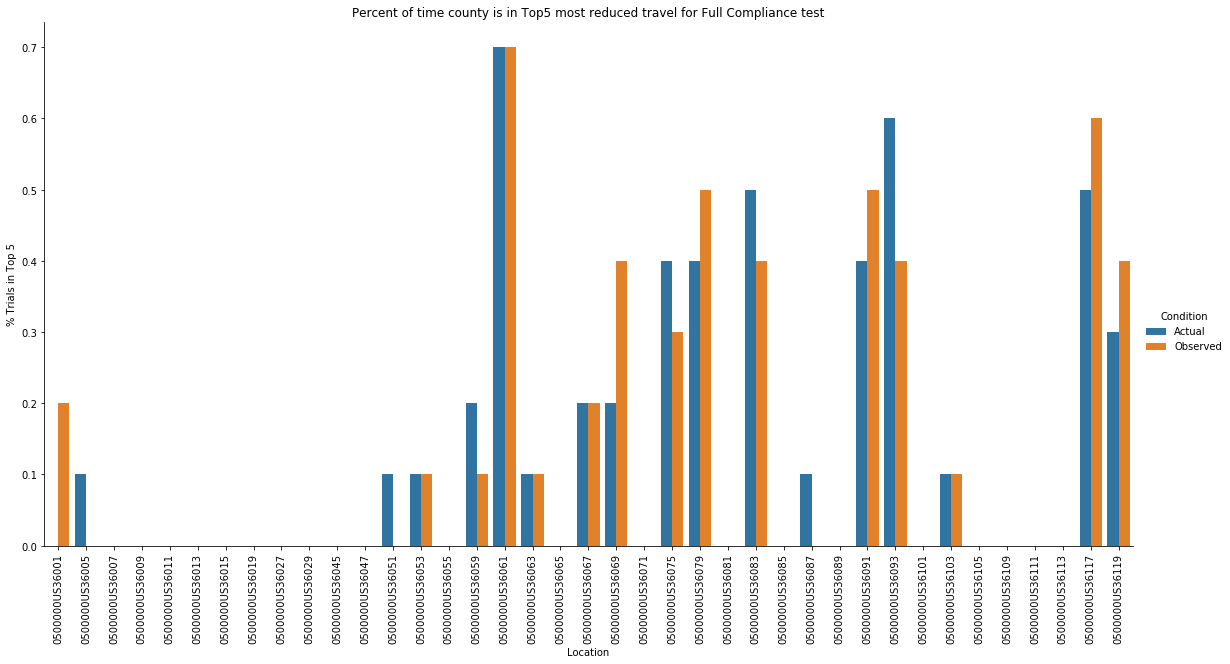

In [562]:
topFivePlot(a,b,'Full Compliance')

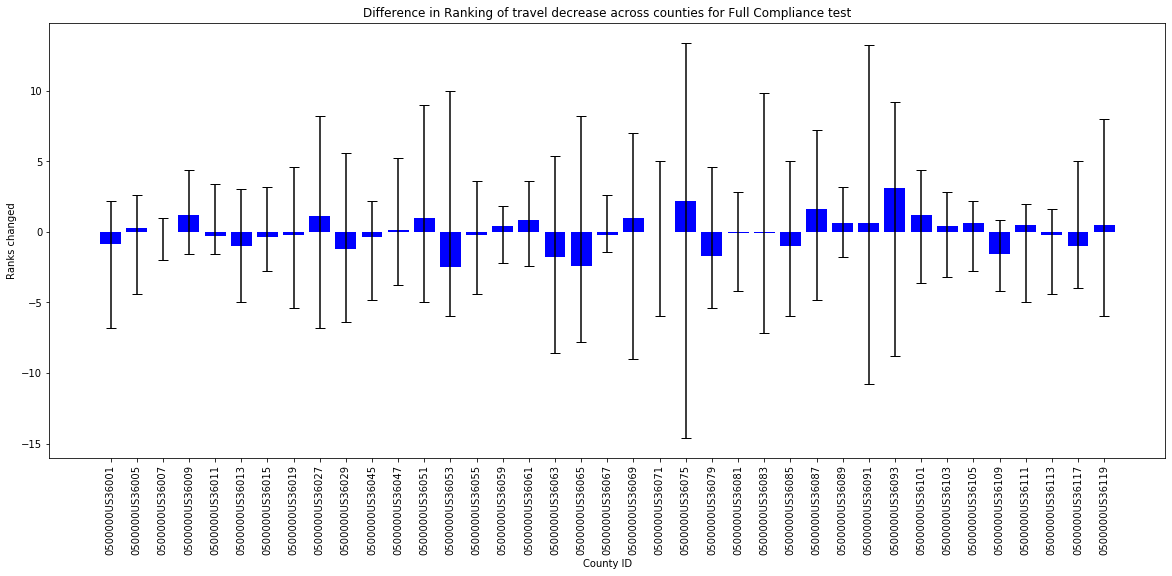

In [565]:
rankchangesPlot(c,'Full Compliance')

In [526]:
# Create new top5 DF
df_top5 = pd.DataFrame(index=np.unique(df_rankactual.index))

# Compute percentage of actual and observed ranks that are within top5
df_top5['Actual'] = df_rankactual.copy().apply(lambda row: len(np.where(row<=5)[0])/10 ,axis=1)
df_top5['Observed'] = df_rankobs.copy().apply(lambda row: len(np.where(row<=5)[0])/10 ,axis=1)
df_top5.reset_index(inplace=True)
df_top5.rename(columns={'index':'Location'},inplace=True)
df_top5.head()

,Location,Actual,Observed
0,0500000US36001,0.0,0.2
1,0500000US36005,0.1,0.0
2,0500000US36007,0.0,0.0
3,0500000US36009,0.0,0.0
4,0500000US36011,0.0,0.0


In [527]:
# Reformat DF for catplot
df_top5_melt = pd.melt(df_top5,id_vars='Location',var_name='Condition',value_name='% Trials in Top 5',value_vars=['Actual','Observed'])
df_top5_melt.sort_values('Location',inplace=True)

<Figure size 1440x576 with 0 Axes>

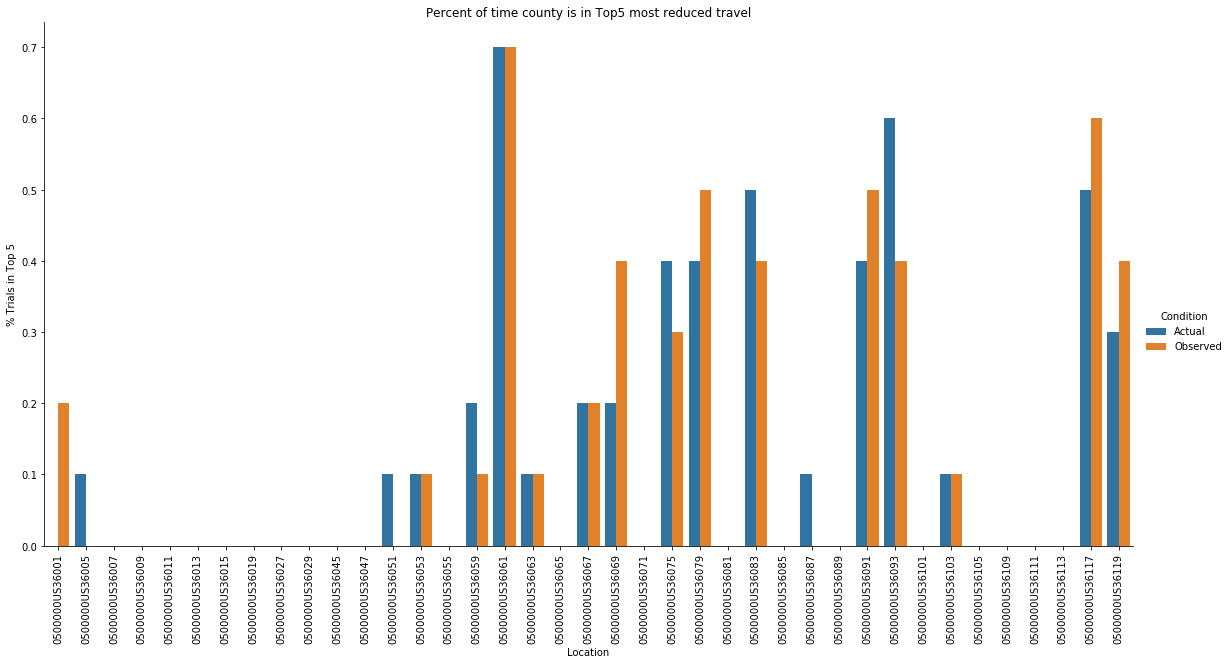

In [528]:
# Plot top5
plt.figure(figsize=(20,8))
g=sns.catplot(x='Location', y="% Trials in Top 5", height=8, aspect=2,hue="Condition", data=df_top5_melt, kind="bar")
g.set_xticklabels(rotation=90)
plt.title('Percent of time county is in Top5 most reduced travel')
plt.show()

<Figure size 1440x576 with 0 Axes>

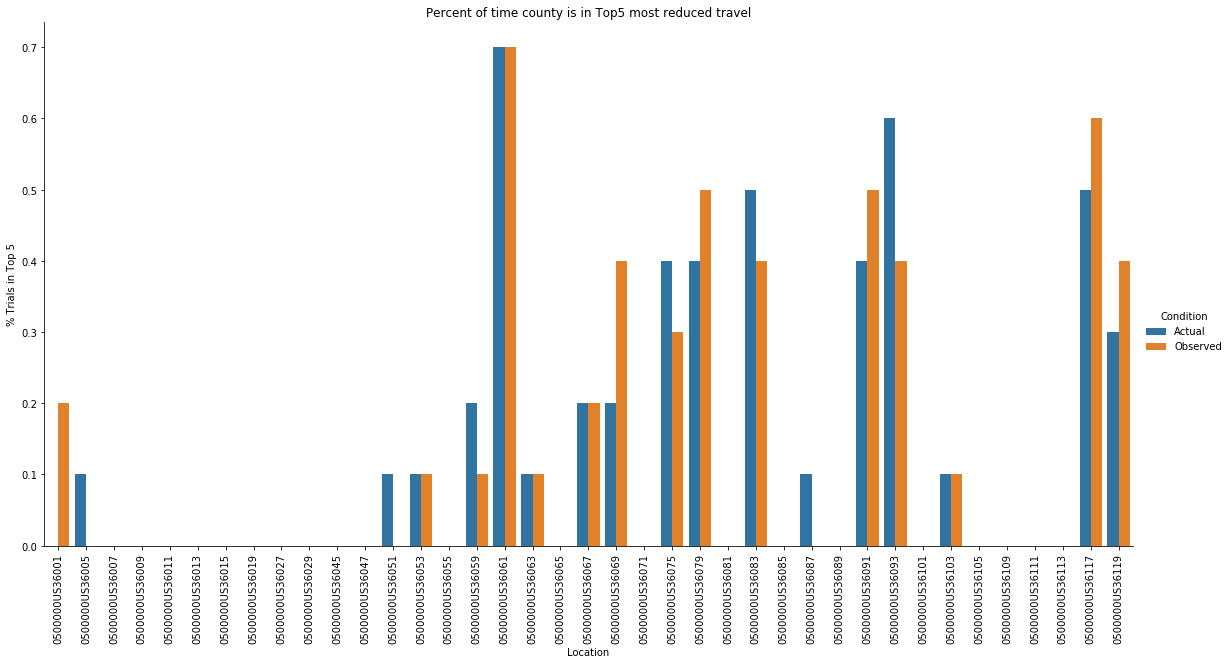

In [499]:
plt.figure(figsize=(20,8))
g=sns.catplot(x='Location', y="% Trials in Top 5", height=8, aspect=2,hue="Condition", data=df_top5_melt, kind="bar")
g.set_xticklabels(rotation=90)
plt.title('Percent of time county is in Top5 most reduced travel')
plt.show()

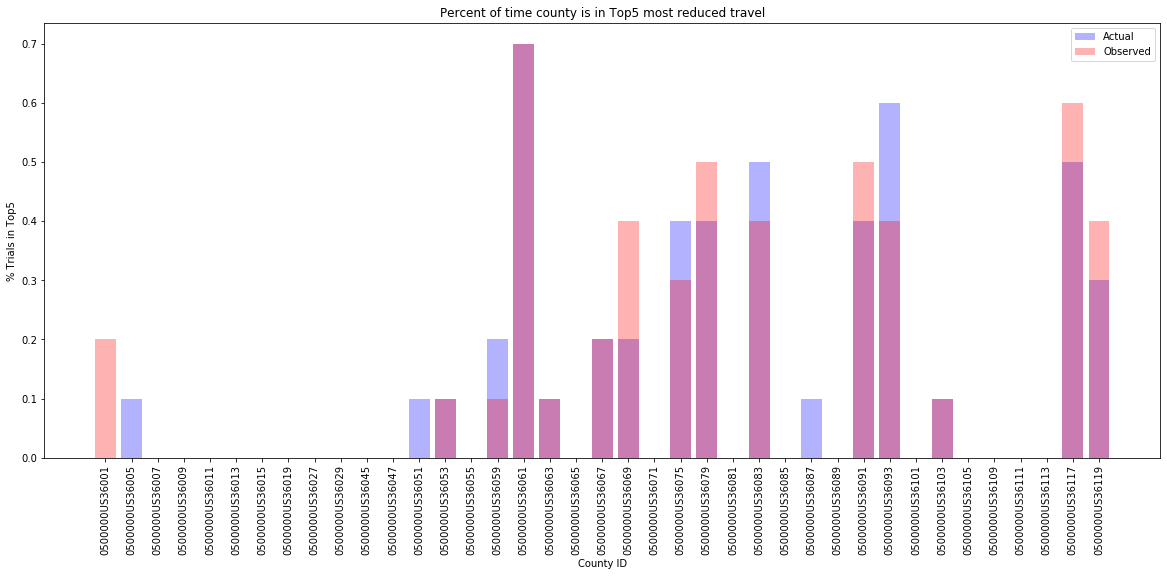

In [416]:
plt.figure(figsize=(20,8))
plt.bar(df_rankactual.index,df_rankactual['Top5'],color='blue',alpha=0.3,label='Actual')
plt.bar(df_rankobs.index,df_rankobs['Top5'],color='red',alpha=0.3,label='Observed')
plt.xticks(rotation=90)
plt.title('Percent of time county is in Top5 most reduced travel')
plt.ylabel('% Trials in Top5')
plt.xlabel('County ID')
plt.legend()
plt.show()

In [395]:
df_rankchanges_all = df_rankchanges.copy(deep=True)
df_rankchanges_all['mean']=df_rankchanges.mean(axis=1)
df_rankchanges_all['minus']=df_rankchanges.mean(axis=1)-df_trials.min(axis=1)
df_rankchanges_all['plus']=df_rankchanges.max(axis=1)-df_trials.mean(axis=1)

In [386]:
df_rankchanges_all.head()

,rank_change_1,rank_change_2,rank_change_3,rank_change_4,rank_change_5,rank_change_6,rank_change_7,rank_change_8,rank_change_9,rank_change_10,mean,minus,plus
0500000US36001,-2.0,-2.0,-1.0,-4.0,-1.0,4.0,-3.0,5.0,-3.0,-2.0,-0.9,3.1,5.9
0500000US36005,5.0,-2.0,0.0,1.0,-2.0,3.0,-2.0,0.0,1.0,-1.0,0.3,2.3,4.7
0500000US36007,-1.0,2.0,-1.0,-1.0,0.0,0.0,1.0,0.0,-1.0,1.0,0.0,1.0,2.0
0500000US36009,1.0,1.0,2.0,-1.0,-2.0,2.0,3.0,2.0,0.0,4.0,1.2,3.2,2.8
0500000US36011,0.0,-4.0,1.0,0.0,0.0,1.0,-1.0,0.0,1.0,-1.0,-0.3,3.7,1.3


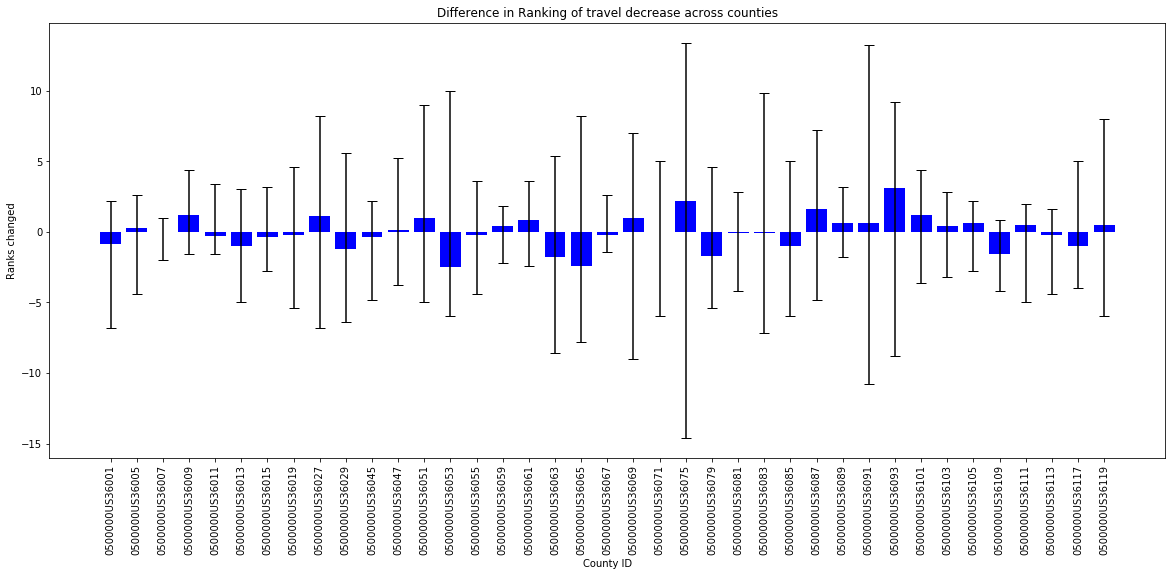

In [387]:
plt.figure(figsize=(20,8))
plt.bar(df_rankchanges_all.index,df_rankchanges_all['mean'],color='blue',yerr=(df_rankchanges_all['plus'],df_rankchanges_all['minus']),capsize=5)
plt.xticks(rotation=90)
plt.title('Difference in Ranking of travel decrease across counties')
plt.ylabel('Ranks changed')
plt.xlabel('County ID')
plt.show()

In [276]:
df.sort_values('observed_change')['location_name'].head()

23    0500000US36079
18    0500000US36065
27    0500000US36087
25    0500000US36083
15    0500000US36059
Name: location_name, dtype: object

In [282]:
df['rank_change']

0      0.0
1      3.0
2     -4.0
3      0.0
4      3.0
5      2.0
6      0.0
7      6.0
8     -3.0
9     -1.0
10    -1.0
11     5.0
12     0.0
13    -3.0
14     5.0
15    -1.0
16     1.0
17    -4.0
18     1.0
19    -1.0
20    -9.0
21    -6.0
22    15.0
23    -2.0
24    -2.0
25     0.0
26    -2.0
27    -2.0
28     0.0
29    -2.0
30     0.0
31     3.0
32     0.0
33    -5.0
34    -3.0
35    -2.0
36     0.0
37     9.0
38     0.0
Name: rank_change, dtype: float64